# **MlFLow**

L’input_example est un exemple concret de donnée d'entrée passée au modèle pour aider MLflow à comprendre ce à quoi ressemblent vos inputs (structure, colonnes, types),
La signature du modèle décrit la forme attendue des entrées et des sorties : les types, dimensions, colonnes.

In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import mlflow
from mlflow.models.signature import infer_signature

MLflow utilise cloudpickle par défaut pour sérialiser les modèles scikit-learn, mais parfois cela pose des problèmes de compatibilité ou pb quand le modèle est trop lourd

- Tracking = Historique = Loguer un modèle= enregistrer le modèle dans une "run" 
- Model Registry = Version finale à déployer = référencer ce modèle dans un catalogue centralisé avec versioning = modèle prêt à être utilisé

### Model tracking

In [31]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [33]:
X_val_scaled = joblib.load("data/X_val_scaled.pkl")
X_val_base = joblib.load("data/X_val_base.pkl")
y_val_split = joblib.load("data/y_val_split.pkl")
X_test_scaled= joblib.load("data/X_test_scaled.pkl")
X_test_base= joblib.load("data/X_test_base.pkl")

# Naive Bayes
best_model_gnb= joblib.load("model/best_model_gnb.pkl")
y_val_proba_gnb= joblib.load("data/y_val_proba_gnb.pkl")
y_val_pred_050_gnb= joblib.load("data/y_val_pred_050_gnb.pkl")
threshold_opt_gnb= joblib.load("data/threshold_opt_gnb.pkl")
y_val_pred_gnb= joblib.load ("data/y_val_pred_gnb.pkl")
metrics_gnb = joblib.load("model/metrics_gnb.pkl")

# Logistic regression
best_model_lr = joblib.load("model/best_model_lr.pkl")
y_val_proba_lr = joblib.load("data/y_val_proba_lr.pkl")
y_val_pred_050_lr = joblib.load("data/y_val_pred_050_lr.pkl")
threshold_opt_lr = joblib.load("data/threshold_opt_lr.pkl")
y_val_pred_opt_lr = joblib.load("data/y_val_pred_opt_lr.pkl")
metrics_lr = joblib.load("model/metrics_lr.pkl")

# LightGBM
best_model_lightgbm = joblib.load("model/best_model_lightgbm.pkl")
y_val_proba = joblib.load("data/y_val_proba.pkl")
y_val_pred_050 = joblib.load("data/y_val_pred_050.pkl")
threshold_opt = joblib.load("data/threshold_opt.pkl")
y_val_pred_opt = joblib.load("data/y_val_pred_opt.pkl")
metrics_lgbm = joblib.load("model/metrics_lgbm.pkl")

# Random Forest
best_model_rf = joblib.load("model/best_model_rf.pkl")
y_val_proba_rf = joblib.load("data/y_val_proba_rf.pkl")
y_val_pred_rf_050 = joblib.load("data/y_val_pred_rf_050.pkl")
threshold_opt_rf = joblib.load("data/threshold_opt_rf.pkl")
y_val_pred_opt_rf = joblib.load("data/y_val_pred_opt_rf.pkl")
metrics_rf = joblib.load("model/metrics_rf.pkl")

# Final model (sur données test) lightgbm avec threshold_opt
final_model = joblib.load("model/final_model_lgbm.pkl")
y_test_proba = joblib.load ("data/y_test_proba_final.pkl")
y_test_pred = joblib.load("data/y_test_pred_final.pkl")

In [50]:

def log_model_to_mlflow(run_name, model_name, model, params, metrics, y_true, y_pred, save_model=True, input_example=None, signature=None):
    """
    Logue un modèle ML avec ses paramètres, métriques et artefacts dans MLflow.

    Args:
        run_name (str): Nom du run MLflow.
        model_name (str): Nom du modèle
        model: Modèle entraîné (objet scikit-learn).
        params (dict): Paramètres du modèle à logguer.
        metrics (dict): Dictionnaire des métriques à logguer (ROC_AUC, F1, etc).
        y_true (array-like): Valeurs réelles (vraies classes) pour la validation.
        y_pred (array-like): Prédictions binaires du modèle.
        save_model (bool): Si True, logue le modèle avec mlflow.sklearn.
        input_example:  Un exemple d’entrée pour le modèle.
        signature: Signature des inputs/outputs.
    """

    # Démarre une nouvelle expérimentation MLflow
    with mlflow.start_run(run_name=run_name):
        
        # Log de paramètres de contexte
        mlflow.log_param("model", model_name)
        mlflow.log_param("smote", True)
        mlflow.log_param("seuil", params.get("threshold", 0.5))

        # Log tous les paramètres spécifiques du modèle
        mlflow.log_params(params)

        # Log les métriques de performance
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name, value)

        # Log du modèle avec sa signature et un input d’exemple
        if save_model:
            mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="model",
                input_example=input_example,
                signature=signature,
                serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE ) #change le format d'enregistrement pour éviter pb de compbabilité

        # Génère et logue la matrice de confusion comme image
        fig, ax = plt.subplots()
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
        plt.title(f"Matrice de confusion - {model_name}")
        fig_path = f"{run_name}_conf_matrix.png"
        fig.savefig(fig_path)
        mlflow.log_artifact(fig_path)




🏃 View run NaiveBayes_SMOTE_Threshold at: http://127.0.0.1:5000/#/experiments/0/runs/f9fb2ff3a6d54b34baca3e53a4921b2a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


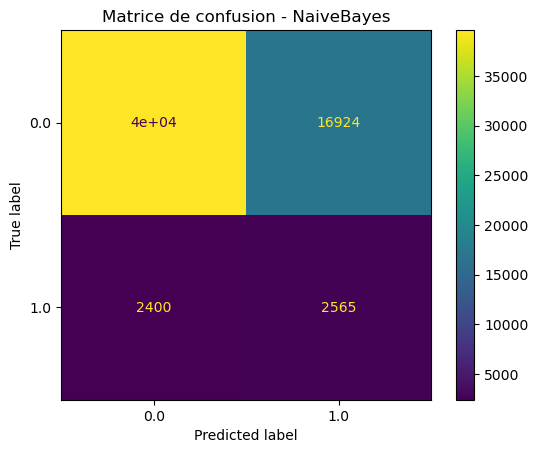

In [35]:
# Naives Bayes
input_example = X_val_scaled[0:1]  # une ligne de validation
signature_gnb = infer_signature(X_val_scaled, y_val_proba_gnb)

params_gnb = {"threshold": threshold_opt_gnb}

log_model_to_mlflow(
    run_name="NaiveBayes_SMOTE_Threshold",
    model_name="NaiveBayes",
    model=best_model_gnb,
    params=params_gnb,
    metrics=metrics_gnb,
    y_true=y_val_split,
    y_pred=y_val_pred_gnb,
    input_example=input_example,
    signature=signature_gnb
)


🏃 View run LogisticRegression_SMOTE_Threshold at: http://127.0.0.1:5000/#/experiments/0/runs/f2d64f3f22f34209ab5698e6dce96b92
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


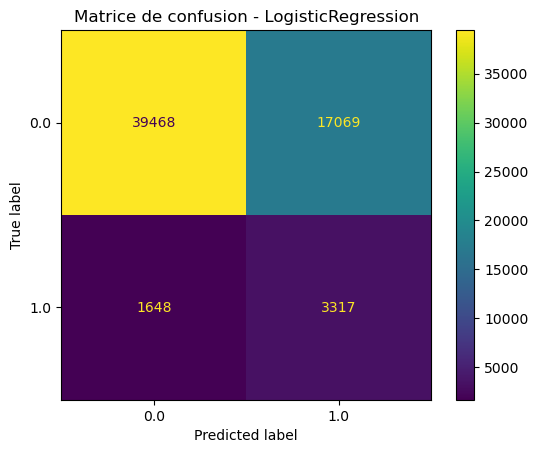

In [36]:
# Logistic regression
input_example = X_val_scaled[0:1]  # une ligne de validation
signature_lr = infer_signature(X_val_scaled, y_val_proba_lr)

params_lr = {"threshold": threshold_opt_lr}

log_model_to_mlflow(
    run_name="LogisticRegression_SMOTE_Threshold",
    model_name="LogisticRegression",
    model=best_model_lr,
    params=params_lr,
    metrics=metrics_lr,
    y_true=y_val_split,
    y_pred=y_val_pred_opt_lr,
    input_example=input_example,
    signature=signature_lr
)


🏃 View run LightGBM_SMOTE_Threshold at: http://127.0.0.1:5000/#/experiments/0/runs/3dc1c224702b494e991b729b02b000f5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


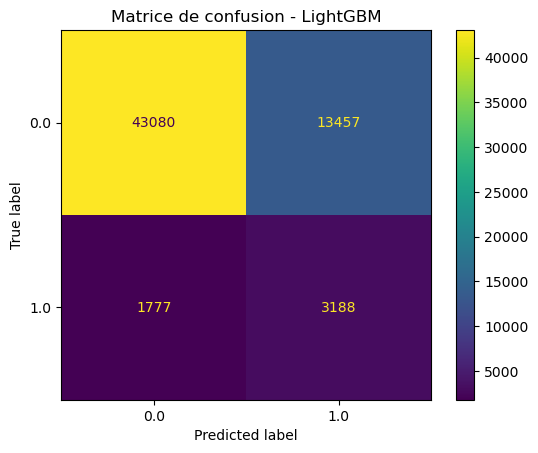

In [41]:
# Lightgbm
input_example = X_val_base[0:1]  # une ligne de validation
signature_lgbm = infer_signature(X_val_base, y_val_proba)

params_lgbm = {"threshold": threshold_opt}

log_model_to_mlflow(
    run_name="LightGBM_SMOTE_Threshold",
    model_name="LightGBM",
    model=best_model_lightgbm,
    params=params_lgbm,
    metrics=metrics_lgbm,
    y_true=y_val_split,
    y_pred=y_val_pred_opt,
    input_example=input_example,
    signature=signature_lgbm
)

In [52]:
# RandomForest

input_example = X_val_base[0:1]  # une ligne de validation
signature_rf = infer_signature(X_val_base, y_val_proba_rf)

params_rf = {"threshold": threshold_opt_rf}

log_model_to_mlflow(
    run_name="RandomForest_SMOTE_Threshold",
    model_name="RandomForest",
    model=best_model_rf,
    params=params_rf,
    metrics=metrics_rf,
    y_true=y_val_split,
    y_pred=y_val_pred_opt_rf,
    input_example=input_example,
    signature=signature_rf
)

🏃 View run RandomForest_SMOTE_Threshold at: http://127.0.0.1:5000/#/experiments/0/runs/2003d3c95efa499188f7db0aa5ccc725
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


MlflowException: API request to http://127.0.0.1:5000/api/2.0/mlflow-artifacts/artifacts/0/2003d3c95efa499188f7db0aa5ccc725/artifacts/model/model.pkl failed with exception HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/0/2003d3c95efa499188f7db0aa5ccc725/artifacts/model/model.pkl (Caused by ProtocolError('Connection aborted.', ConnectionResetError(10054, 'Une connexion existante a dû être fermée par l’hôte distant', None, 10054, None)))

### Model Registry

In [54]:
# interface pour parler au serveur MLflow (via l’API)
from mlflow.tracking import MlflowClient

client = MlflowClient() # permet d'interagir avec Mlflow 
result = client.create_registered_model("LightGBM") # créée une fiche d'identité du modèle 

# Enregistrer la dernière version du modèle logué dans le registry
run_id = "3dc1c224702b494e991b729b02b000f5" 
model_uri = f"runs:/{run_id}/model"

# créée le modèle versionné et officiel
client.create_model_version(
    name="LightGBM",
    source=model_uri,
    run_id=run_id
)


2025/05/05 21:11:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 1


<ModelVersion: aliases=[], creation_timestamp=1746472296587, current_stage='None', description='', last_updated_timestamp=1746472296587, name='LightGBM', run_id='3dc1c224702b494e991b729b02b000f5', run_link='', source='runs:/3dc1c224702b494e991b729b02b000f5/model', status='READY', status_message=None, tags={}, user_id='', version='1'>

In [71]:
import requests

# L'URL de ton endpoint FastAPI
url = "http://127.0.0.1:8000/predict"

# Exemple de données d'entrée (tu dois adapter selon ton schéma exact)
data = {
    "CODE_GENDER": 1,
    "FLAG_OWN_CAR": 0,
    "FLAG_OWN_REALTY": 1,
    "CNT_CHILDREN": 0,
    "AMT_INCOME_TOTAL": 120000.0,
    "AMT_CREDIT": 500000.0,
    "AMT_ANNUITY": 25000.0,
    "AMT_GOODS_PRICE": 450000.0,
    "REGION_POPULATION_RELATIVE": 0.0188,
    "CNT_FAM_MEMBERS": 2.0,
    "REGION_RATING_CLIENT_W_CITY": 2,
    "EXT_SOURCE_1": 0.5,
    "EXT_SOURCE_2": 0.7,
    "EXT_SOURCE_3": 0.6,
    "YEARS_BUILD_AVG": 20.0,
    "TOTALAREA_MODE": 35.0,
    "DEF_60_CNT_SOCIAL_CIRCLE": 1.0,
    "IS_UNEMPLOYED": False,
    "BURO_DAYS_CREDIT_MEAN": -300.0,
    "BURO_AMT_CREDIT_SUM_MEAN": 120000.0,
    "BURO_AMT_CREDIT_SUM_OVERDUE_MEAN": 0.0,
    "BURO_CREDIT_DAY_OVERDUE_MEAN": 0.0,
    "PREV_AMT_CREDIT_MAX": 100000.0,
    "PREV_AMT_APPLICATION_MEAN": 110000.0,
    "PREV_APP_CREDIT_PERC_MEAN": 0.9,
    "PREV_DAYS_DECISION_MIN": -100.0,
    "POS_SK_DPD_MEAN": 0.0,
    "POS_SK_DPD_DEF_MEAN": 0.0,
    "INSTAL_PAYMENT_DIFF_MEAN": 0.0,
    "INSTAL_PAYMENT_DIFF_MAX": 0.0,
    "INSTAL_DPD_MEAN": 0.0,
    "CC_AMT_BALANCE_MEAN": 50000.0,
    "CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN": 15000.0,
    "CC_SK_DPD_MAX": 0.0,
    "DAYS_EMPLOYED_PERC": 0.3,
    "INCOME_PER_PERSON": 60000.0,
    "ANNUITY_INCOME_PERC": 0.2,
    "PAYMENT_RATE": 0.05,
    "CREDIT_TERM": 20.0,
    "AGE": 35,
    
    # Variables catégorielles (exemples, adapte selon ton modèle)
    "NAME_CONTRACT_TYPE_Revolving loans": False,
    "NAME_INCOME_TYPE_Commercial associate": False,
    "NAME_EDUCATION_TYPE_Secondary / secondary special": True,
    "NAME_HOUSING_TYPE_House / apartment": True,
    "NAME_INCOME_TYPE_Pensioner": False,
    "NAME_INCOME_TYPE_State servant": False,
    "NAME_INCOME_TYPE_Unemployed": False,
    "NAME_INCOME_TYPE_Working": True,
    "NAME_EDUCATION_TYPE_Higher education": False,
    "NAME_EDUCATION_TYPE_Lower secondary": False,
    "NAME_FAMILY_STATUS_Married": True,
    "NAME_FAMILY_STATUS_Single / not married": False,
    "NAME_FAMILY_STATUS_Widow": False,
    "NAME_HOUSING_TYPE_Office apartment": False,
    "NAME_HOUSING_TYPE_Rented apartment": False,
    "NAME_HOUSING_TYPE_With parent": False,
    "SECTOR_Industry": True,
    "SECTOR_Trade": False,
    "SECTOR_Transport": False,
    "SECTOR_Business Entity": False,
    "SECTOR_Government": False,
    "SECTOR_Security": False,
    "SECTOR_Services": True,
    "SECTOR_Construction": False,
    "SECTOR_Medicine": False,
    "SECTOR_Police": False,
    "SECTOR_Other": False,
    "OCCUPATION_Labor_Work": False,
    "OCCUPATION_Sales_Services": True,
    "OCCUPATION_Medical_Staff": False,
    "OCCUPATION_Security": False,
    "OCCUPATION_Management_Core": False,
    "OCCUPATION_Other": False
}

# Envoi de la requête POST
response = requests.post(url, json=data)

# Affichage de la réponse
print("✅ Résultat de l'API :")
print(response.json())


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000025482F794E0>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))

### FastAPI

Objectif: Créer une API FastAPI qui :
- charge automatiquement le modèle versionné depuis le Model Registry MLflow
- prend des données en entrée (toutes les features)
- retourne une probabilité de défaut + une décision (accepté/refusé)